In [1]:
import pandas as pd
import numpy as np
import warnings
import mrmr
warnings.filterwarnings("ignore")

In [2]:
# Define the list of feature names
feature_names =  ['age', 'rank', 'height', 'weight', 'bmi', 'bp_s', 'bp_d', 'bp', 'map', 'smoker', 'alcohol', 'faam', 'eilp', 'chronicity', 'ttp', 'ttd', 'ttt', 'wait time', 'time_dg', 'co_morb', 'prior_injuries', 'prior_surgery', 'prior_courses']

# Read the feature data from a CSV file into a Pandas DataFrame
X = pd.read_csv('data//X.csv', header=None)

# Assign the feature names to the columns of the DataFrame
X.columns = feature_names

# Read the target variable (labels) from a CSV file into a Pandas DataFrame
y = pd.read_csv('data//y.csv', header=None)

# Assign a column name ('labels') to the target variable
y.columns = ['labels']

# Use the mrmr_classif function to select features based on minimum redundancy maximum relevance
selected_features = mrmr.mrmr_classif(X, y.iloc[:, 0].values, K=X.shape[1])

# Initialize a list with the first selected feature
valid_features = [selected_features[0]]

# Iterate over the remaining selected features and check for correlation with already selected features
for feat in range(1, X.shape[1]):
    # Check if the absolute correlation between the current feature and the valid features is greater than 0.5
    if any(abs(X[valid_features + [selected_features[feat]]].corr().iloc[:-1, -1].values) > 0.5):
        # If the correlation is greater than 0.5, skip adding the feature to the valid features list
        pass
    else:
        # If the correlation is not greater than 0.5, add the feature to the valid features list
        valid_features.append(selected_features[feat])

# Create a new DataFrame (X_) containing only the selected valid features
X_ = X[valid_features].copy().values
y_ = y['labels'].values

100%|██████████| 23/23 [00:04<00:00,  5.72it/s]


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from interrogation_analysis import MisclassificationExplainer
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve

Optimization terminated successfully.
         Current function value: 0.281427
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.484242
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.433828
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486619
         Iterations 5
0.19047619047619047


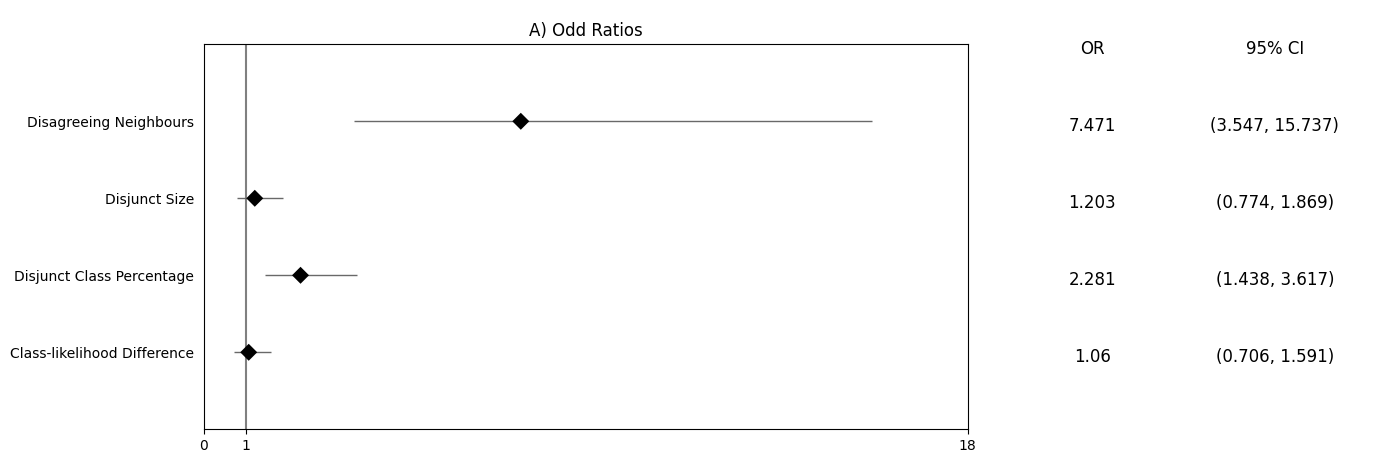

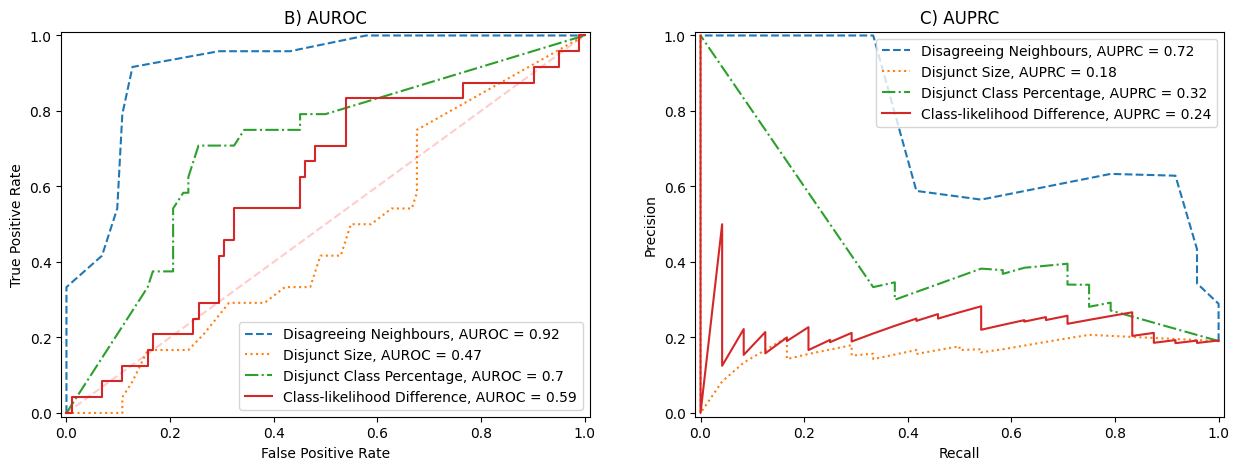

In [4]:
import statsmodels.api as sm
import scipy.stats as stats
from imblearn.over_sampling import RandomOverSampler

model = LogisticRegression(class_weight='balanced',C=0.25,penalty='l2',solver='liblinear')
misclassification_explainer = MisclassificationExplainer(balanced=True, categorical_idx=[2,3,7,9,10,14,15], n_neighbors=10, max_depth=4)

# Create StratifiedKFold object for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

misclassifications_ = []
scores_ = []
oversampler = RandomOverSampler(random_state=42)

for train_index, val_index in skf.split(X_, y_):
    X_train, X_val = X_[train_index], X_[val_index]
    y_train, y_val = y_[train_index], y_[val_index]

    # Make predictions using the provided model
    X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)
    model.fit(X_train_resampled, y_train_resampled)
    
    misclassification_explainer.fit(X_train_resampled, y_train_resampled)

    y_pred = model.predict(X_val)

    # Identify misclassifications
    misclassifications = y_pred != y_val

    # Calculate heuristic scores using the implemented method
    scores = misclassification_explainer.calculate_heuristics(X_val, y_val)

    misclassifications_.append(misclassifications)
    scores_.append(scores)

misclassifications = np.hstack(misclassifications_)
new_scores = {}
for name in scores.keys():
    heuristic = []
    for i in range(5):
        heuristic.append(scores_[i][name])
    new_scores[name] = np.hstack(heuristic)
scores = new_scores

results = {}
for heuristic, heuristic_scores in scores.items():
    
    if heuristic in ['Disagreeing Neighbours', 'Disjunct Class Percentage']:
        # Standardize heuristic scores using z-score normalization
        heuristic_scores_ = stats.zscore(heuristic_scores)
    else:
        # Standardize heuristic scores using z-score normalization
        heuristic_scores_ = -stats.zscore(heuristic_scores)
    # Add a constant term for logistic regression
    heuristic_scores_ = sm.add_constant(heuristic_scores_)

    # Fit logistic regression model to predict misclassifications using heuristic scores
    res = sm.Logit(misclassifications, heuristic_scores_).fit()

    # Calculate Area Under the Receiver Operating Characteristic (AUROC) and Area Under the Precision-Recall Curve (AUPRC) score
    auroc = roc_auc_score(misclassifications, heuristic_scores)
    auprc = average_precision_score(misclassifications, heuristic_scores)

    # Generate ROC and Precision-Recall curve
    fpr, tpr, _ = roc_curve(misclassifications, heuristic_scores)
    precision, recall, _ = precision_recall_curve(misclassifications, heuristic_scores)

    # Store results for the current heuristic
    results[heuristic] = {
        'odds_ratio': np.exp(res.params[1]).round(3),
        'confidence_interval': np.exp(res.conf_int()[1,:]).round(3),
        'pvalue': res.pvalues[1].round(3),
        'auroc': auroc.round(3),
        'auprc': auprc.round(3),
        'roc_curve': {'fpr': list(fpr), 'tpr': list(tpr)},
        'precision_recall_curve': {'precision': list(precision), 'recall': list(recall)}
    }

misclassification_explainer.results = results
misclassification_explainer.plot_results()
print(np.mean(misclassifications))